# LOAD LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import r2_score

# READ DATA

## FLUXES

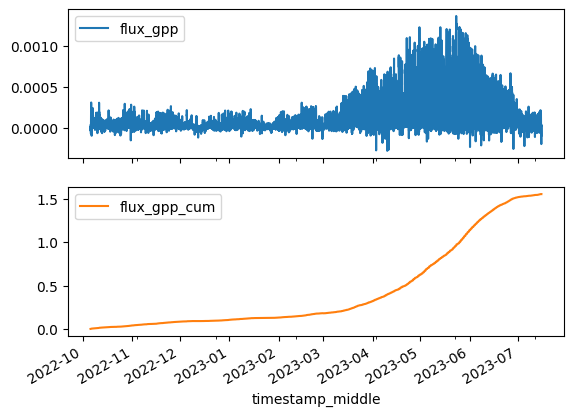

In [3]:
time_resolution = '0.5' # set time resolution in hours

file_path = 'data/processed/DRIVERS_dataset_' + time_resolution + 'h.csv'
data = pd.read_csv(file_path, low_memory=False)

# Fix column names so all lower case, no spaces or special characters
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace(r'[^a-zA-Z0-9_]', '')
# Fix date to a datetime object
if time_resolution == '24':
    data['timestamp_middle'] = pd.to_datetime(data['timestamp_middle'], format='%Y-%m-%d')
else:
    data['timestamp_middle'] = pd.to_datetime(data['timestamp_middle'], format='%Y-%m-%d %H:%M:%S')
# Set timestamp as index
data.set_index('timestamp_middle', inplace=True)

# Calculate cumulative GPP over the wheat growing season
# Define start and end of wheat growing season
start = '2022-10-06'
end = '2023-07-15'
data = data[start:end]
flux_col = 'flux_gpp'
# Comvert GPP to kg C m-2 per time interval
data[flux_col] = data[flux_col] * 60 * 30 * 12.011 * 1e-9 # umol CO2 m-2 s-1 → kg C m-2 30min-1
flux_cum_col = flux_col + '_cum'
data[flux_cum_col] = np.nan
flux = data[[flux_col, flux_cum_col]].copy()
flux[flux_cum_col] = flux[flux_col].cumsum()

# Plot
indat = flux.copy()
indat.plot(x_compat=True, subplots=True);

## BIOMASS

Function to process data

In [5]:
def process_data(df, date_col, *cols):
    # Convert date column to datetime and create a timestamp
    df['timestamp_middle'] = pd.to_datetime(df[date_col] + ' 12:15:00', errors='coerce')
    df.set_index('timestamp_middle', inplace=True)
    # Allow a single list/tuple as *cols
    if len(cols) == 1 and isinstance(cols[0], (list, tuple)):
        cols = tuple(cols[0])
    # Keep only requested columns that actually exist
    requested = list(cols) if cols else []
    present = [c for c in requested if c in df.columns]
    # Return the processed dataframe
    return df[present].copy()

,crop_n_mean,crop_n_std,crop_c_mean,crop_c_std
timestamp_middle,,,,
2022-08-08 12:15:00,67.254739,41.775008,1040.989635,651.172980
2022-09-19 12:15:00,40.208529,7.080058,496.043257,68.417138
2022-12-13 12:15:00,13.523177,4.942409,152.578025,57.913578
2023-02-07 12:15:00,13.088847,6.216587,167.923569,79.889697
2023-03-17 12:15:00,26.571133,6.256560,282.963236,67.408786
2023-04-14 12:15:00,60.642784,22.372266,842.765710,332.478283
2023-05-19 12:15:00,132.026081,38.453690,3440.560746,925.083475
2023-06-28 12:15:00,177.699312,31.322448,7455.852217,1106.134281
2023-07-11 12:15:00,162.159666,52.806195,6861.008830,1995.956791


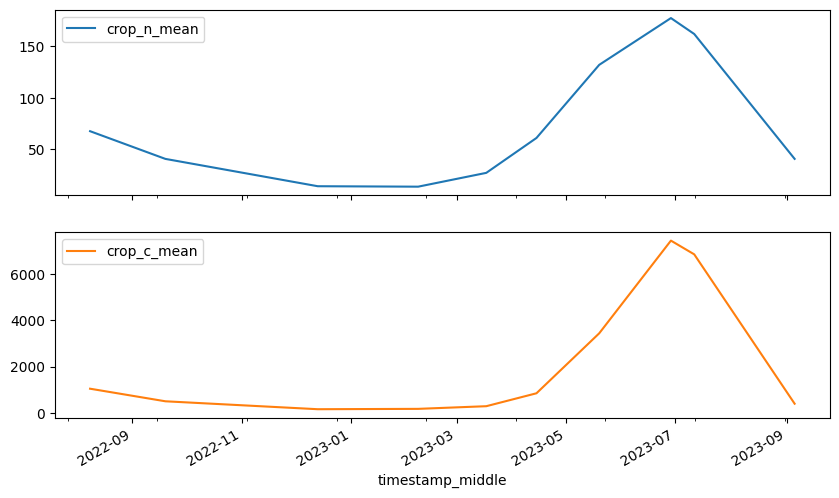

In [9]:
biom = pd.read_csv('data/raw/crop_biomass.csv')
biom = process_data(biom, 'date', 'crop_n_mean', 'crop_n_std', 'crop_c_mean', 'crop_c_std')

# Plot
indat = biom.copy()
start = '2022-01-01'
end = '2023-10-05'
indat = indat[['crop_n_mean', 'crop_c_mean']][start:end]
indat.plot(figsize=(10,6), x_compat=True, subplots=True);

biom

# ANALYSIS

## EXPLORATORY

Scatterplots of cumulative GPP versus the crop biomass variables

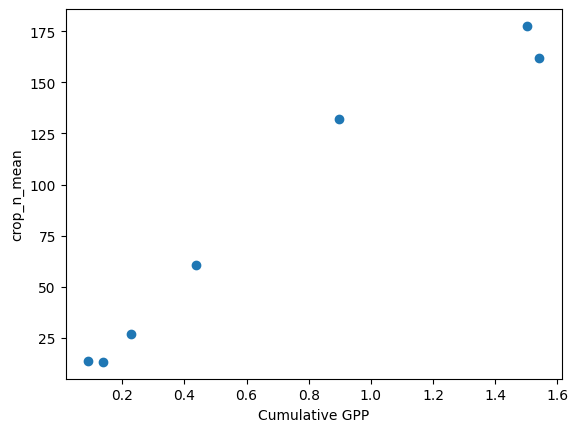

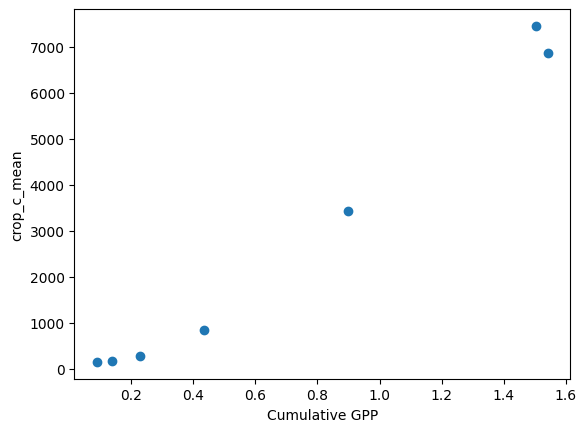

In [ ]:
df = pd.merge(flux, biom, how='outer', left_index=True, right_index=True)

cols = ['crop_n_mean', 'crop_c_mean']

for col in cols:
    indat = df[[col, flux_cum_col]].dropna()
    # Create scatter plot
    plt.scatter(indat[flux_cum_col], indat[col])
    plt.xlabel('Cumulative GPP')
    plt.ylabel(col)
    # Show the plot
    plt.show()

## LINEAR REGRESSION
GPP vs crop N

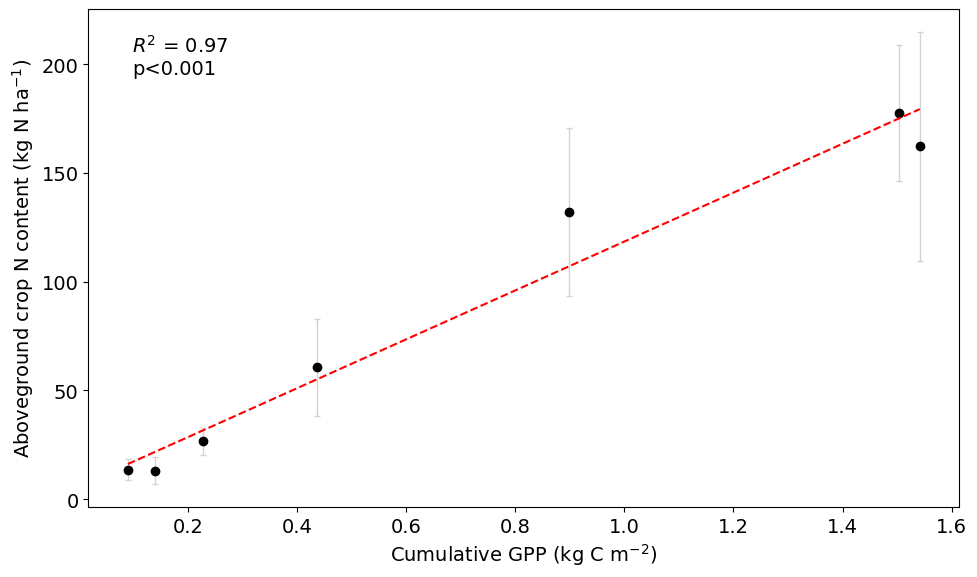

In [12]:
# Helper to format p-values
def format_p(p):
    if p < 0.001:
        return "<0.001"
    elif p < 0.05:
        return "<0.05"
    else:
        return f"={p:.2f}"
    
def plot_linear(ax, df, col='crop_n_mean', col_stdev = 'crop_n_std'):

    indat = df[[flux_cum_col, col, col_stdev]].dropna().copy()
    # Extracting the relevant data
    X = indat[flux_cum_col].values  # Independent variable
    y = indat[col].values  # Dependent variable
    y_std = indat[col_stdev].values # Standard deviation for error bars
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = linregress(X, y)
    r2 = r2_score(y, slope * X + intercept)
    y_pred = slope * X + intercept

    # Plot
    ax.scatter(X, y, c='black', zorder=2)
    ax.errorbar(X, y, yerr=y_std, fmt='none', ecolor='lightgray', elinewidth=1, capsize=2, zorder=1)
    ax.plot(indat[flux_cum_col], y_pred, color='red', linestyle='--')

    # Add labels (dates) to each point
    # for i, date in enumerate(indat[col]):
    #     plt.text(indat[flux_cum_col].iloc[i], indat[col].iloc[i], str(indat.index[i].date()), fontsize=8)

    # R² and p-value as annotation
    ax.annotate(f'$R^2$ = {r2:.2f}\np{format_p(p_value)}', xy=(0.05, 0.95),
                xycoords='axes fraction', ha='left', va='top')

    # Adding title and labels
    ax.set_xlabel('Cumulative GPP (kg C m$^{-2}$)')
    ax.set_ylabel('Aboveground crop N content (kg N ha$^{-1}$)')

# Call the plot function
plt.rcParams.update({'font.size': 14})  # Set global font size
fig, ax = plt.subplots(figsize=(10, 6))
plot_linear(ax, df)
plt.tight_layout()
plt.savefig('figures/GPP_vs_cropN.png', dpi=300)
plt.show()